In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow_datasets as tfds
import os
import csv

plt.style.use('ggplot')

In [2]:
def create_dataset():
#A batch méret beállítása
    batch_size = 32
# Adatok betöltése a mappából, data loader segítségével
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets",  
        # A mappa ahol az adatok vannak, a daganattípusoknak megfelelő almappákba rendezve
    batch_size=batch_size,  # Batch mérete
    labels="inferred",  # Az almappák alapján rendeli hozzá a címkét az egyes képekhez
    shuffle=True,  # Az adatok keverése
    seed=42  # Reprodukálható eredményekhez
        )

# A dataset méretének meghatározása
    dataset_size = len(dataset)  # A teljes adatméret
    train_size = int(0.7 * dataset_size)  # 70% tréning
    val_size = int(0.2 * dataset_size)  # 20% validáció
    test_size = dataset_size - train_size - val_size  # 10% teszt

# Felosztás (train - val - test)
    training_dataset = dataset.take(train_size)  # Az első 70%-ot veszi
    remaining = dataset.skip(train_size)  # A maradék 30% az elosztásra

    validation_dataset = remaining.take(val_size)  # A következő 20% validációs adatok
    test_dataset = remaining.skip(val_size)  # A maradék 10% teszt adatok

#Normálás elvégzése:
    def normalize(image, label):
        image = tf.cast(image, tf.float32) / 255.0  # Normálás 0-1 közé
        return image, label

# Normálás alkalmazása
    training_dataset = training_dataset.map(normalize)
    validation_dataset = validation_dataset.map(normalize)
    test_dataset = test_dataset.map(normalize)

    # Visszatérési érték: 3 db data_loader objektum
    return training_dataset, validation_dataset, test_dataset

In [3]:
tr,val,ts=create_dataset()
print(len(tr))
print(len(val))
print(len(ts))

Found 15000 files belonging to 3 classes.
328
93
48


In [48]:
class ConvBlock(tf.keras.models.Model):

    def __init__(self, out_channels, padding="same"):
        super(ConvBlock, self).__init__()
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size=(3, 3), padding=padding, activation="relu")
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.pooling = tf.keras.layers.MaxPool2D()

    def call(self, input):
        x = self.conv2d(input)
        x = self.batchnorm(x)
        return self.pooling(x)

class ConvBlock_reg(tf.keras.models.Model):

    def __init__(self, out_channels, padding="same"):
        super(ConvBlock_reg, self).__init__()
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size=(3, 3), padding=padding, activation="relu",kernel_regularizer=tf.keras.regularizers.l2(0.02))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.pooling = tf.keras.layers.MaxPool2D()

    def call(self, input):
        x = self.conv2d(input)
        x = self.batchnorm(x)
        return self.pooling(x)


#Adataugmentációs modellrész: véletlenszerűen tükrözi, forgatja, és zoomol az adatba
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(256,
                                  256,
                                  3)),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.15),
  ]
)


In [5]:
"""#A learning rate logolása batchenként
class BatchLearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super().__init__()
        self.lrs = []
        self.filepath = filepath
        with open(self.filepath, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Batch", "Learning Rate"])  # Fejléc

    def on_train_batch_end(self, batch, logs=None):
        # Az aktuális learning rate érték lekérdezése
        lr = float(self.model.optimizer.learning_rate.numpy())
        self.lrs.append(lr)
        # Írd hozzá az értéket a fájlhoz
        with open(self.filepath, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([batch + 1, lr])"""

#A training loss logolása batchenként
class BatchLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super().__init__()
        self.losses = []
        self.filepath = filepath # Fájl elérési út 
        with open(self.filepath, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Batch", "Loss"]) 

    def on_train_batch_end(self, batch, logs=None):
        loss = logs.get('loss')
        self.losses.append(loss)
        with open(self.filepath, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([batch + 1, loss])

#A training accuracy logolása batcheneként
class BatchAccCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super().__init__()
        self.accs = []
        self.filepath=filepath
        with open(self.filepath, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Batch", "Accuracy"]) 

    def on_train_batch_end(self, batch, logs=None):
        acc = logs.get('accuracy')  # Batch pontossága (ha van megadva)
        self.accs.append(acc)
        with open(self.filepath, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([batch + 1, acc])

class ValidationAccCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super().__init__()
        self.accs = []
        self.filepath=filepath
        with open(self.filepath, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Batch", "Accuracy"]) 

    def on_test_batch_end(self, batch, logs=None):
        """
        Minden validációs batch végén meghívódik.
        """
        if logs is not None:
            # Tároljuk a validációs veszteséget és pontosságot
            acc=logs.get("accuracy")
            self.accs.append(logs.get('accuracy'))
            with open(self.filepath, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([batch + 1, acc])

class ValidationLossCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath):
        super().__init__()
        self.losses = []
        self.filepath=filepath
        with open(self.filepath, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Batch", "Loss"]) 

    def on_test_batch_end(self, batch, logs=None):
        """
        Minden validációs batch végén meghívódik.
        """
        if logs is not None:
            # Tároljuk a validációs veszteséget és pontosságot
            loss=logs.get("loss")
            self.losses.append(logs.get('loss'))
            with open(self.filepath, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([batch + 1, loss])

In [52]:
#A modell illesztését, és a tanítás folyamatának logolását elvégző függvény
def fitlog(num_epochs,model_name, loss_log_file, acc_log_file, val_acc_log_file,val_loss_log_file,lr=0.001):
    model_name.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #lr_log_file = lr_log_file
    #loss_log_file = loss_log_file
    batch_loss_logger = BatchLossCallback(filepath=loss_log_file)
    #acc_log_file = acc_log_file
    batch_acc_logger = BatchAccCallback(filepath=acc_log_file)
    #val_acc_log_file= ValidationAccCallback()
    val_loss_logger=ValidationLossCallback(filepath=val_loss_log_file)
    val_acc_logger=ValidationAccCallback(filepath=val_acc_log_file)
    training_dataset, validation_dataset, test_dataset = create_dataset()
    history = model_name.fit(
      training_dataset,
      validation_data=validation_dataset,
      epochs=num_epochs,
      callbacks=[batch_loss_logger, batch_acc_logger,val_loss_logger, val_acc_logger]
    )
    print("A tesztelés eredménye:")
    test_loss, test_acc = model_name.evaluate(test_dataset, verbose=2)
    return history, batch_loss_logger.losses, batch_acc_logger.accs, val_loss_logger.losses, val_acc_logger.accs

In [ ]:
baseline_model = tf.keras.Sequential([
    ConvBlock(8),                         
    ConvBlock(16),
    ConvBlock(32),
    ConvBlock(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])
baseline_history, baseline_loss, baseline_acc, baseline_val_loss, baseline_val_acc, = fitlog(5,baseline_model,"/kaggle/working/baseline_loss.txt","/kaggle/working/baseline_acc.txt"
                                                                                            ,"/kaggle/working/baseline_val_loss.txt","/kaggle/working/baseline_val_acc.txt")

In [36]:
baseline_model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block_36 (ConvBlock)       │ ?                      │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_37 (ConvBlock)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_38 (ConvBlock)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_39 (ConvBlock)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256 (1.00 KB)

 Trainable params: 240 (960.00 B)

 Non-trainable params: 16 (64.00 B)

In [ ]:
less_model = tf.keras.Sequential([
    ConvBlock(8),                         
    ConvBlock(16),
    ConvBlock(32),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])
less_history1, less_loss1, less_acc1, less_val_loss1, less_val_acc1 = fitlog(5,less_model,"/kaggle/working/less_loss.txt","/kaggle/working/less_acc.txt"
                                                                                            ,"/kaggle/working/less_val_loss.txt","/kaggle/working/less_val_acc.txt")

In [37]:
less_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block_4 (ConvBlock)        │ (None, 128, 128, 8)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_5 (ConvBlock)        │ (None, 64, 64, 16)     │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_6 (ConvBlock)        │ (None, 32, 32, 32)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,356,347 (192.09 MB)

 Trainable params: 16,785,411 (64.03 MB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 33,570,824 (128.06 MB)

In [9]:
bigger_model = tf.keras.Sequential([
    ConvBlock(8),                         
    ConvBlock(16),
    ConvBlock(32),
    ConvBlock(64),
    ConvBlock(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])
bigger_history, bigger_loss, bigger_acc, bigger_val_loss, bigger_val_acc = fitlog(5,bigger_model,"/kaggle/working/bigger_loss.txt","/kaggle/working/bigger_acc.txt"
                                                                                            ,"/kaggle/working/bigger_val_loss.txt","/kaggle/working/bigger_val_acc.txt")

Found 15000 files belonging to 3 classes.
Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 39s 94ms/step - accuracy: 0.8185 - loss: 0.9766 - val_accuracy: 0.4677 - val_loss: 3.7786
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.9210 - loss: 0.2210 - val_accuracy: 0.9143 - val_loss: 0.2047
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 32s 96ms/step - accuracy: 0.9494 - loss: 0.1344 - val_accuracy: 0.9237 - val_loss: 0.2085
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9630 - loss: 0.0942 - val_accuracy: 0.9610 - val_loss: 0.1148
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.9698 - loss: 0.0738 - val_accuracy: 0.9439 - val_loss: 0.1745
A tesztelés eredménye:
48/48 - 18s - 381ms/step - accuracy: 0.9529 - loss: 0.1574


In [38]:
bigger_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block_7 (ConvBlock)        │ (None, 128, 128, 8)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_8 (ConvBlock)        │ (None, 64, 64, 16)     │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_9 (ConvBlock)        │ (None, 32, 32, 32)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_10 (ConvBlock)       │ (None, 16, 16, 64)     │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_11 (ConvBlock)       │ (None, 8, 8, 64)       │        37,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,483,451 (24.73 MB)

 Trainable params: 2,161,027 (8.24 MB)

 Non-trainable params: 368 (1.44 KB)

 Optimizer params: 4,322,056 (16.49 MB)

In [10]:
#Az alap modell, rétegenkénti regularizációval kiegészítve
reg_model = tf.keras.Sequential([
    ConvBlock_reg(8),                         
    ConvBlock_reg(16),
    ConvBlock_reg(32),
    ConvBlock_reg(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])
reg_history, reg_loss, reg_acc, reg_val_loss, reg_val_acc = fitlog(5,reg_model,"/kaggle/working/reg_loss.txt","/kaggle/working/reg_acc.txt"
                                                                                            ,"/kaggle/working/reg_val_loss.txt","/kaggle/working/reg_val_acc.txt")

Found 15000 files belonging to 3 classes.
Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.8300 - loss: 17.1763 - val_accuracy: 0.3569 - val_loss: 6.8267
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.8797 - loss: 2.2707 - val_accuracy: 0.6667 - val_loss: 2.0813
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.9030 - loss: 1.3139 - val_accuracy: 0.9096 - val_loss: 1.0053
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.9143 - loss: 0.9627 - val_accuracy: 0.8589 - val_loss: 1.0690
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9169 - loss: 0.8324 - val_accuracy: 0.9372 - val_loss: 0.7107
A tesztelés eredménye:
48/48 - 19s - 389ms/step - accuracy: 0.9476 - loss: 0.6720


In [39]:
reg_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block_reg (ConvBlock_reg)  │ (None, 128, 128, 8)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_1                │ (None, 64, 64, 16)     │         1,232 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_2                │ (None, 32, 32, 32)     │         4,768 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_3                │ (None, 16, 16, 64)     │        18,752 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,246,523 (96.31 MB)

 Trainable params: 8,415,427 (32.10 MB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 16,830,856 (64.20 MB)

In [11]:
drop_model = tf.keras.Sequential([
    ConvBlock(8),                         
    ConvBlock(16),
    ConvBlock(32),
    ConvBlock(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(3)
])
drop_history, drop_loss, drop_acc, drop_val_loss, drop_val_acc = fitlog(5,drop_model,"/kaggle/working/drop_loss.txt","/kaggle/working/drop_acc.txt"
                                                                                            ,"/kaggle/working/drop_val_loss.txt","/kaggle/working/drop_val_acc.txt")

Found 15000 files belonging to 3 classes.
Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 38s 93ms/step - accuracy: 0.8135 - loss: 1.8977 - val_accuracy: 0.6132 - val_loss: 2.1444
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step - accuracy: 0.9122 - loss: 0.2465 - val_accuracy: 0.9375 - val_loss: 0.1732
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 93ms/step - accuracy: 0.9422 - loss: 0.1564 - val_accuracy: 0.8958 - val_loss: 0.4191
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step - accuracy: 0.9515 - loss: 0.1406 - val_accuracy: 0.9640 - val_loss: 0.1035
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 30s 92ms/step - accuracy: 0.9524 - loss: 0.1326 - val_accuracy: 0.8841 - val_loss: 0.5183
A tesztelés eredménye:
48/48 - 18s - 374ms/step - accuracy: 0.9018 - loss: 0.4294


In [41]:
drop_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block_12 (ConvBlock)       │ (None, 128, 128, 8)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_13 (ConvBlock)       │ (None, 64, 64, 16)     │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_14 (ConvBlock)       │ (None, 32, 32, 32)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_15 (ConvBlock)       │ (None, 16, 16, 64)     │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,246,523 (96.31 MB)

 Trainable params: 8,415,427 (32.10 MB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 16,830,856 (64.20 MB)

In [12]:
#Az alap modell, adataugmentációval kiegészítve
aug_model = tf.keras.Sequential([
    data_augmentation,
    ConvBlock(8),                         # 32 szűrős konvolúciós blokk
    ConvBlock(16),
    ConvBlock(32),
    ConvBlock(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])
aug_history, aug_loss, aug_acc, aug_val_loss, aug_val_acc = fitlog(5,aug_model,"/kaggle/working/aug_loss.txt","/kaggle/working/aug_acc.txt"
                                                                                            ,"/kaggle/working/aug_val_loss.txt","/kaggle/working/aug_val_acc.txt")

Found 15000 files belonging to 3 classes.
Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 43s 112ms/step - accuracy: 0.8346 - loss: 1.2977 - val_accuracy: 0.3716 - val_loss: 21.7427
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.8963 - loss: 0.2744 - val_accuracy: 0.9214 - val_loss: 0.1880
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 36s 111ms/step - accuracy: 0.9177 - loss: 0.2029 - val_accuracy: 0.9237 - val_loss: 0.1895
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - accuracy: 0.9325 - loss: 0.1684 - val_accuracy: 0.9180 - val_loss: 0.2246
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 111ms/step - accuracy: 0.9294 - loss: 0.1976 - val_accuracy: 0.8095 - val_loss: 0.5600
A tesztelés eredménye:
48/48 - 19s - 396ms/step - accuracy: 0.8233 - loss: 0.5543


In [42]:
aug_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_16 (ConvBlock)       │ (None, 128, 128, 8)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_17 (ConvBlock)       │ (None, 64, 64, 16)     │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_18 (ConvBlock)       │ (None, 32, 32, 32)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_19 (ConvBlock)       │ (None, 16, 16, 64)     │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,246,523 (96.31 MB)

 Trainable params: 8,415,427 (32.10 MB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 16,830,856 (64.20 MB)

In [13]:
augnreg_model = tf.keras.Sequential([
    data_augmentation,
    ConvBlock_reg(8),                         # 32 szűrős konvolúciós blokk
    ConvBlock_reg(16),
    ConvBlock_reg(32),
    ConvBlock_reg(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])
augnreg_history, augnreg_loss, augnreg_acc, augnreg_val_loss, augnreg_val_acc = fitlog(5,augnreg_model,"/kaggle/working/augnreg_loss0.txt","/kaggle/working/augnreg_acc0.txt"
                                                                                            ,"/kaggle/working/augnreg_val_loss0.txt","/kaggle/working/augnreg_val_acc0.txt")

Found 15000 files belonging to 3 classes.
Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 114ms/step - accuracy: 0.7891 - loss: 20.3901 - val_accuracy: 0.3703 - val_loss: 8.6394
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 113ms/step - accuracy: 0.8899 - loss: 1.7041 - val_accuracy: 0.8723 - val_loss: 1.3993
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.8988 - loss: 1.2189 - val_accuracy: 0.6781 - val_loss: 1.6812
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 113ms/step - accuracy: 0.9071 - loss: 0.9660 - val_accuracy: 0.7826 - val_loss: 1.3000
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.9193 - loss: 0.7774 - val_accuracy: 0.9099 - val_loss: 0.7823
A tesztelés eredménye:
48/48 - 18s - 375ms/step - accuracy: 0.9208 - loss: 0.7430


In [43]:
augnreg_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_4                │ (None, 128, 128, 8)    │           256 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_5                │ (None, 64, 64, 16)     │         1,232 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_6                │ (None, 32, 32, 32)     │         4,768 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_7                │ (None, 16, 16, 64)     │        18,752 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,246,523 (96.31 MB)

 Trainable params: 8,415,427 (32.10 MB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 16,830,856 (64.20 MB)

In [16]:
baseline_model1 = tf.keras.Sequential([
    ConvBlock(8),                         
    ConvBlock(16),
    ConvBlock(32),
    ConvBlock(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])
baseline_history1, baseline_loss1, baseline_acc1, baseline_val_loss1, baseline_val_acc1, = fitlog(10,baseline_model1,"/kaggle/working/baseline_loss1.txt","/kaggle/working/baseline_acc1.txt"
                                                                                            ,"/kaggle/working/baseline_val_loss1.txt","/kaggle/working/baseline_val_acc1.txt",0.0001)

Found 15000 files belonging to 3 classes.
Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step - accuracy: 0.7995 - loss: 0.6067 - val_accuracy: 0.5817 - val_loss: 1.7609
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9237 - loss: 0.1790 - val_accuracy: 0.9227 - val_loss: 0.1774
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9648 - loss: 0.0923 - val_accuracy: 0.9516 - val_loss: 0.1180
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9830 - loss: 0.0476 - val_accuracy: 0.9546 - val_loss: 0.1225
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9831 - loss: 0.0473 - val_accuracy: 0.9136 - val_loss: 0.2864
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9927 - loss: 0.0261 - val_accuracy: 0.9627 - val_loss: 0.1001
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms/step - accuracy: 0.9939 - loss: 0.0183 - val_accuracy: 0.9644 - val_loss: 0.1122
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 31s 94ms

In [44]:
baseline_model1.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block_28 (ConvBlock)       │ (None, 128, 128, 8)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_29 (ConvBlock)       │ (None, 64, 64, 16)     │         1,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_30 (ConvBlock)       │ (None, 32, 32, 32)     │         4,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_31 (ConvBlock)       │ (None, 16, 16, 64)     │        18,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,246,523 (96.31 MB)

 Trainable params: 8,415,427 (32.10 MB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 16,830,856 (64.20 MB)

In [21]:
def fitlog1(num_epochs,model_name, loss_log_file, acc_log_file, val_acc_log_file,val_loss_log_file,lr=0.001):
    model_name.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    #lr_log_file = lr_log_file
    #loss_log_file = loss_log_file
    batch_loss_logger = BatchLossCallback(filepath=loss_log_file)
    #acc_log_file = acc_log_file
    batch_acc_logger = BatchAccCallback(filepath=acc_log_file)
    #val_acc_log_file= ValidationAccCallback()
    val_loss_logger=ValidationLossCallback(filepath=val_loss_log_file)
    val_acc_logger=ValidationAccCallback(filepath=val_acc_log_file)
    training_dataset, validation_dataset, test_dataset = create_dataset()
    history = model_name.fit(
      training_dataset,
      validation_data=validation_dataset,
      epochs=num_epochs,
      callbacks=[batch_loss_logger, batch_acc_logger,val_loss_logger, val_acc_logger]
    )
    print("A tesztelés eredménye:")
    test_loss, test_acc = model_name.evaluate(test_dataset, verbose=2)
    probability_model = tf.keras.Sequential([model_name,
                                         tf.keras.layers.Softmax()])
    class_names=["adenocarcinoma", "beingn tumor", "SCC"]
    for images, labels in test_dataset.take(1):  # Csak az első batch
        plt.figure(figsize=(10, 10))
        for i in range(9):  # 9 képet jelenítünk meg
            prediction = probability_model.predict(tf.reshape(images[i], (1, 256, 256, 3)))[0]
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow((images[i]*255.0).numpy().astype("uint8"))  # Kép megjelenítése
            plt.title("GT: "+class_names[labels[i]])  # Címke szöveges megjelenítése
        #plt.axis("off")  # Tengelyek elrejtése
            if class_names[labels[i]] == class_names[np.argmax(prediction)]:
                color = 'green'
            else:
                color = 'red'
            plt.xlabel("Pred: "+class_names[np.argmax(prediction)] + " ("+str(np.round(np.max(prediction)*100,2))+"%) \n ")
            plt.grid(False)
    plt.suptitle("Az aug. + reg. modell hosszabb tanításának verifikációja")
    plt.tight_layout()
    plt.show()
    plt.savefig("verification.png")
    return history, batch_loss_logger.losses, batch_acc_logger.accs, val_loss_logger.losses, val_acc_logger.accs

Found 15000 files belonging to 3 classes.
Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 113ms/step - accuracy: 0.8120 - loss: 39.0052 - val_accuracy: 0.4600 - val_loss: 15.1230
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 111ms/step - accuracy: 0.8927 - loss: 9.5703 - val_accuracy: 0.9415 - val_loss: 4.1444
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - accuracy: 0.9196 - loss: 3.5086 - val_accuracy: 0.9429 - val_loss: 2.1819
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.9357 - loss: 2.0297 - val_accuracy: 0.9533 - val_loss: 1.6016
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - accuracy: 0.9311 - loss: 1.5808 - val_accuracy: 0.9446 - val_loss: 1.3876
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 114ms/step - accuracy: 0.9465 - loss: 1.3558 - val_accuracy: 0.9499 - val_loss: 1.2053
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 37s 112ms/step - accuracy: 0.9472 - loss: 1.1944 - val_accuracy: 0.9429 - val_loss: 1.1182
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━

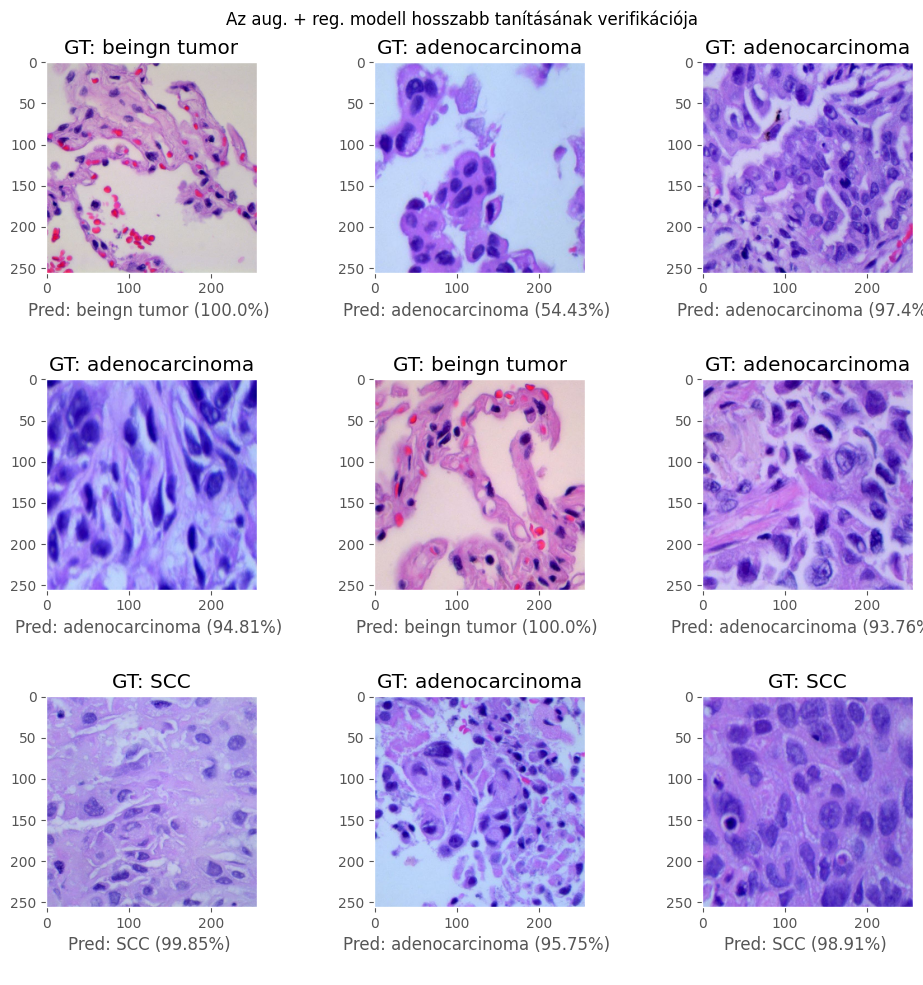

<Figure size 640x480 with 0 Axes>

In [22]:
augnreg_model1 = tf.keras.Sequential([
    data_augmentation,
    ConvBlock_reg(8),                         # 32 szűrős konvolúciós blokk
    ConvBlock_reg(16),
    ConvBlock_reg(32),
    ConvBlock_reg(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.05)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])
augnreg_history1, augnreg_loss1, augnreg_acc1, augnreg_val_loss1, augnreg_val_acc1 = fitlog1(10,augnreg_model1,"/kaggle/working/augnreg_loss1.txt","/kaggle/working/augnreg_acc1.txt"
                                                                                            ,"/kaggle/working/augnreg_val_loss1.txt","/kaggle/working/augnreg_val_acc1.txt",0.0001)

In [46]:
augnreg_model1.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_12               │ (None, 128, 128, 8)    │           256 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_13               │ (None, 64, 64, 16)     │         1,232 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_14               │ (None, 32, 32, 32)     │         4,768 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_reg_15               │ (None, 16, 16, 64)     │        18,752 │
│ (ConvBlock_reg)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,246,523 (96.31 MB)

 Trainable params: 8,415,427 (32.10 MB)

 Non-trainable params: 240 (960.00 B)

 Optimizer params: 16,830,856 (64.20 MB)

In [23]:
def plotter(loss,acc,val_loss,val_acc, filename, title):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training Accuracy')

    plt.subplot(2, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.title('Training Loss')

    plt.subplot(2, 2, 3)
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Val Accuracy')

    plt.subplot(2, 2, 4)
    plt.plot(val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Val Loss')
    plt.suptitle(title)
    plt.savefig(filename+".png")

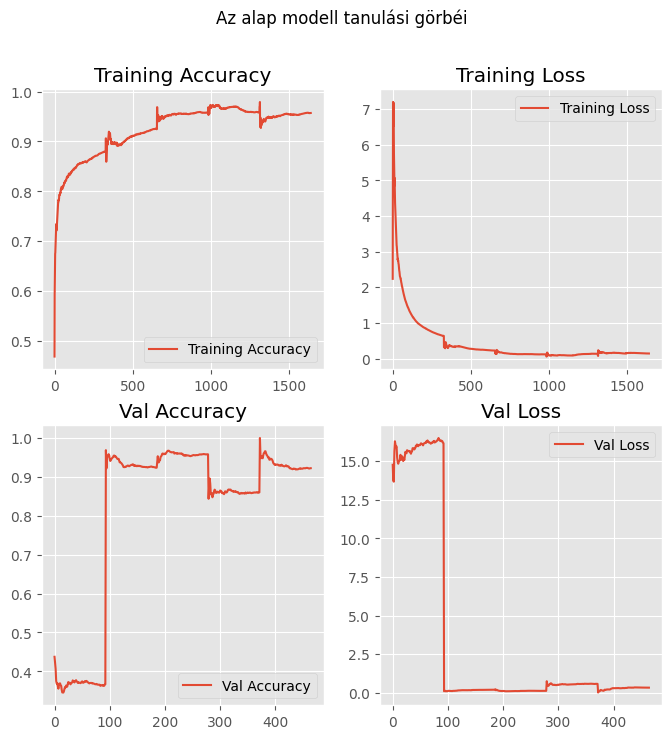

In [24]:
plotter(baseline_loss,baseline_acc,baseline_val_loss,baseline_val_acc, "baseline", "Az alap modell tanulási görbéi")

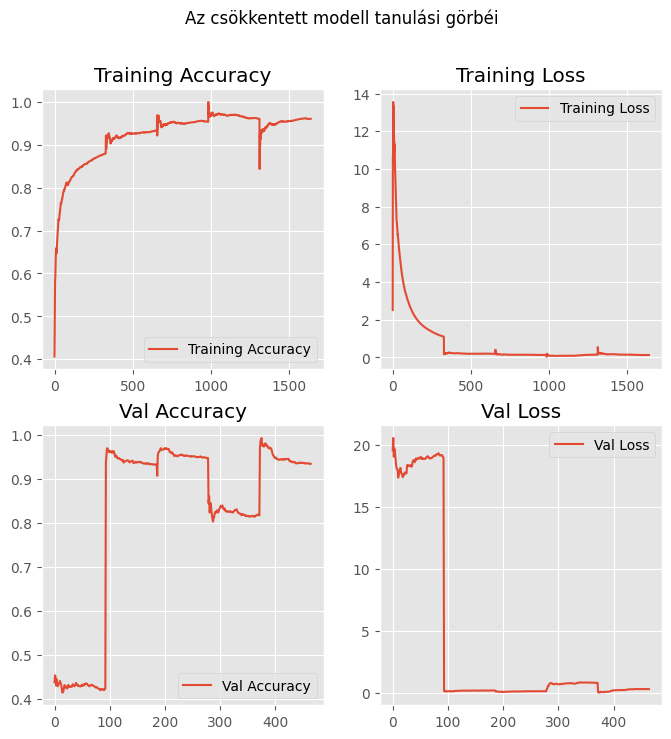

In [25]:
plotter(less_loss,less_acc,less_val_loss,less_val_acc, "less", "Az csökkentett modell tanulási görbéi")

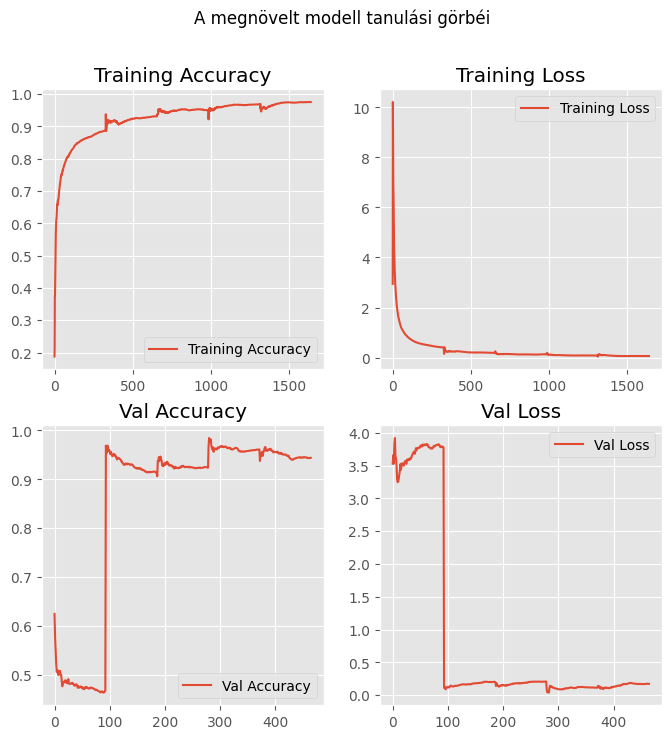

In [26]:
plotter(bigger_loss,bigger_acc,bigger_val_loss,bigger_val_acc, "bigger", "A megnövelt modell tanulási görbéi")

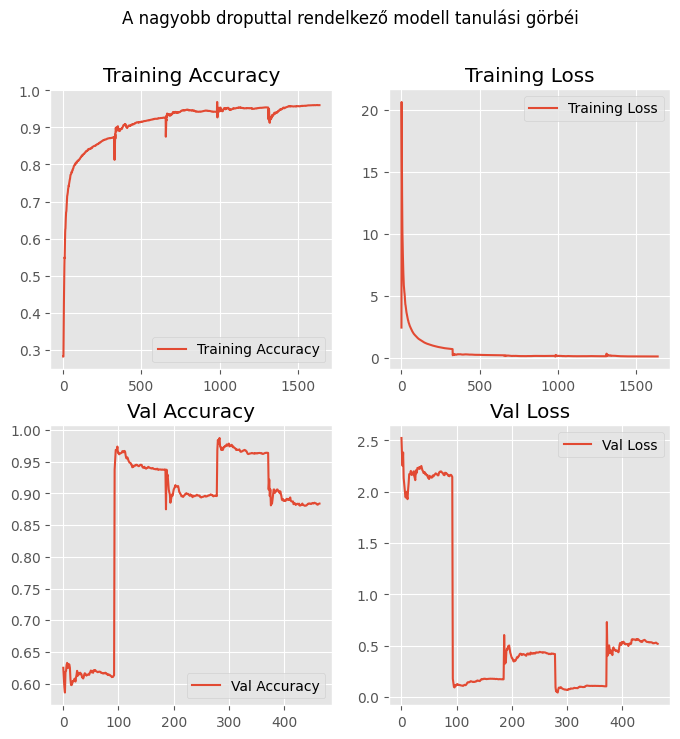

In [28]:
plotter(drop_loss,drop_acc,drop_val_loss,drop_val_acc, "A nagyobb dropouttal rendelkező modell tanulási görbéi", "A nagyobb droputtal rendelkező modell tanulási görbéi")

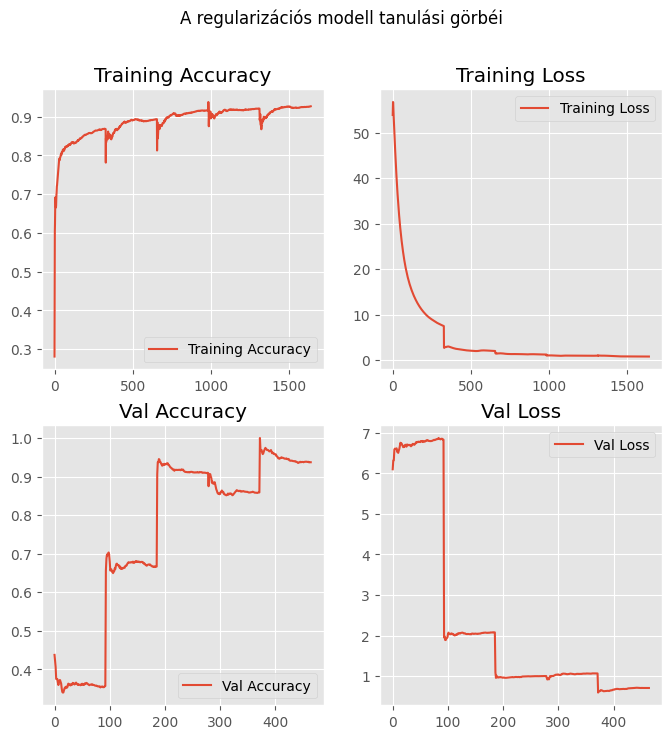

In [29]:
plotter(reg_loss,reg_acc,reg_val_loss,reg_val_acc, "reg", "A regularizációs modell tanulási görbéi")

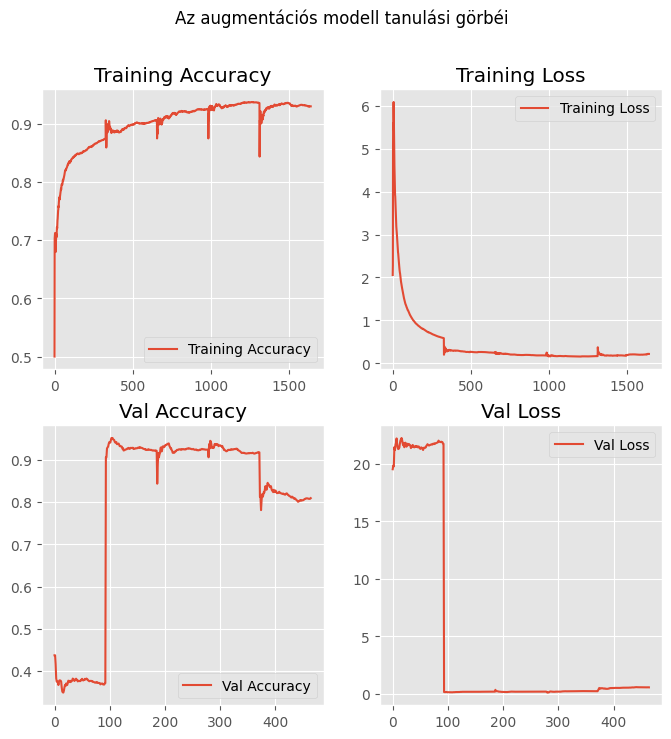

In [30]:
plotter(aug_loss,aug_acc,aug_val_loss,aug_val_acc, "aug", "Az augmentációs modell tanulási görbéi")

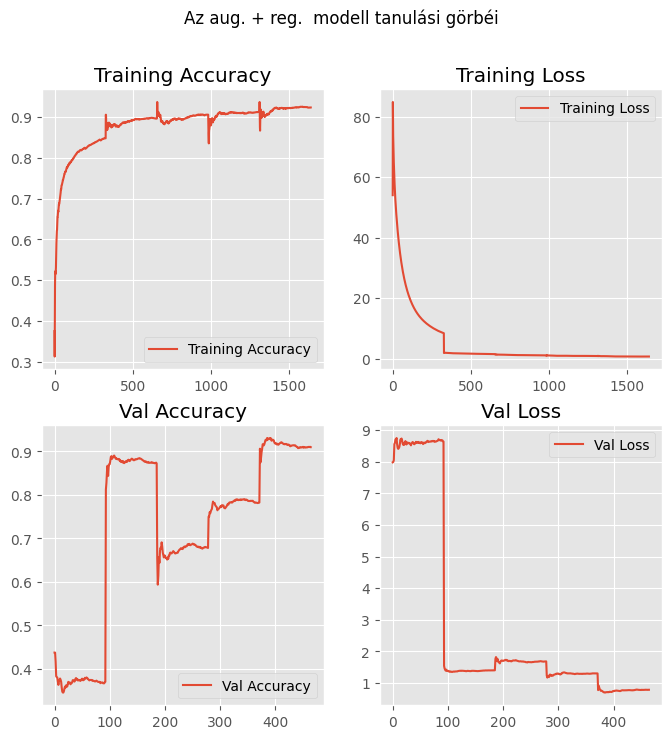

In [31]:
plotter(augnreg_loss,augnreg_acc,augnreg_val_loss,augnreg_val_acc, "augreg",  "Az aug. + reg.  modell tanulási görbéi")

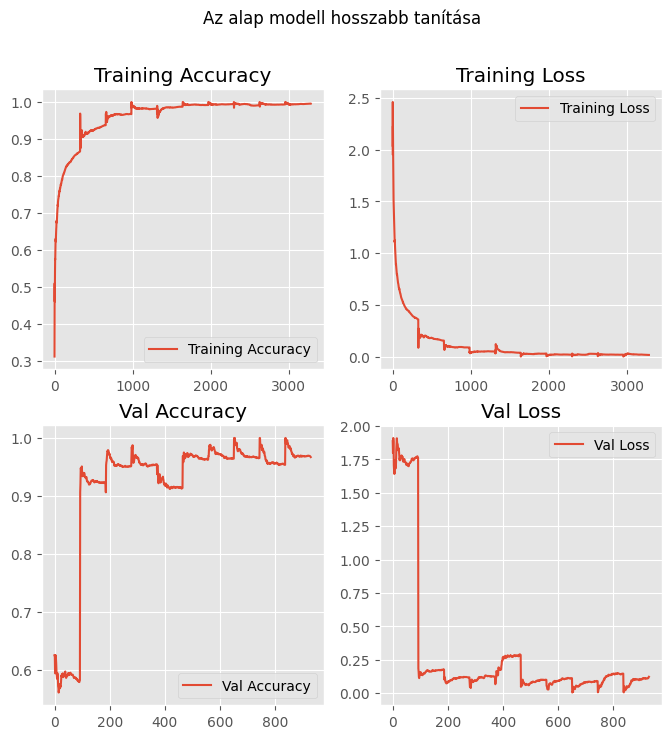

In [32]:
plotter(baseline_loss1,baseline_acc1,baseline_val_loss1,baseline_val_acc1, "baseline_slow", "Az alap modell hosszabb tanítása")

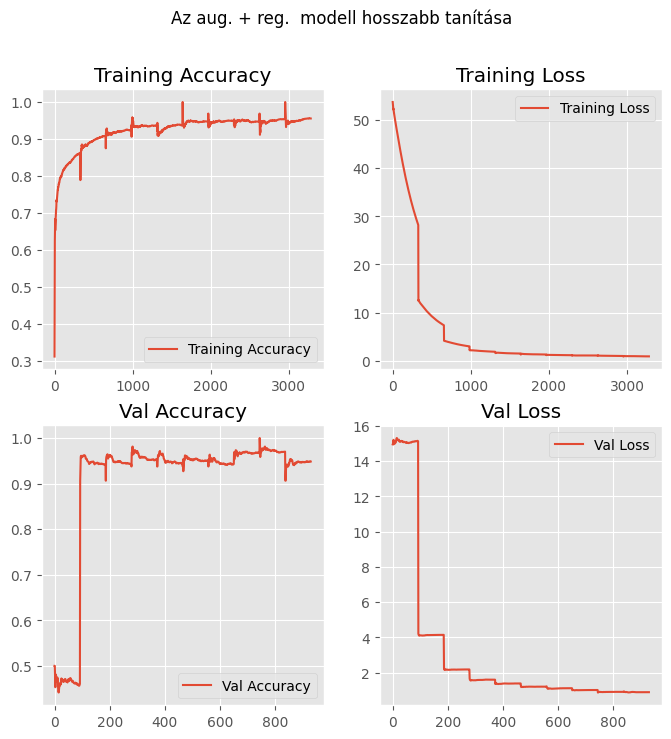

In [33]:
plotter(augnreg_loss1,augnreg_acc1,augnreg_val_loss1,augnreg_val_acc1, "augreg1",  "Az aug. + reg.  modell hosszabb tanítása")

In [58]:
!tar -czf output.tar.gz /kaggle/working/

tar: Removing leading `/' from member names
